In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep

In [2]:
class CustomFrozenLakeWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        row, col = divmod(self.env.unwrapped.s, self.env.unwrapped.ncol)
        tile = self.env.unwrapped.desc[row, col]

        if tile == b'G':  # Goal
            return 100
        elif tile == b'H':  # Hole
            return -100
        else:  # Frozen tile
            return -1

In [3]:
class CliffBoy(gym.Env):
    def __init__(self,gridsize,cliff_size=1):
        super(CliffBoy,self).__init__()
        self.gridsize=gridsize

        self.action_space=gym.spaces.Discrete(4)
        self.observation_space=gym.spaces.Discrete(gridsize*gridsize)

        self.ground=np.zeros((gridsize,gridsize),dtype=object)
        
        self.state=(0,0)

        self.cum_reward=0

        cliff_seed=self.random_position()
        cliff_direction=np.random.randint(0,2)
        for i in range(cliff_size):
            self.ground[
                (cliff_seed[0]+(i*(np.abs(cliff_direction-1))))%gridsize,
                (cliff_seed[1]+(i*cliff_direction))%gridsize
            ]='C'

        self.goal=(gridsize-1,gridsize-1)
        self.ground[self.goal[0],self.goal[1]]='G'


    def step(self,action,check_step=False):
        x,y=self.state

        if action == 0:  # Left
            y = max(0, y - 1)
        elif action == 1:  # Down
            x = min(self.gridsize - 1, x + 1)
        elif action == 2:  # Right
            y = min(self.gridsize - 1, y + 1)
        elif action == 3:  # Up
            x = max(0, x - 1)

        state = (x, y)

        reward = self.get_reward(state)
        self.cum_reward+=reward

        done = self.ground[x, y] == 'C' or self.ground[x, y] == 'G'

        if(not check_step):
            self.state=state

        return self._get_state_index(state), reward, done, {},{}

    def get_reward(self,state):
        if(state==(self.gridsize-1,self.gridsize-1)):
            return 100
        elif(self.ground[state[0],state[1]]=='C'):
            return -100
        else:
            return -1

    def reset(self):
        self.state = (0, 0)
        return [self._get_state_index(self.state)]

    def _get_state_index(self,state):
        return state[0] * self.gridsize + state[1]

    def random_position(self):
        return [np.random.randint(1,self.gridsize),np.random.randint(1,self.gridsize)]

    def render(self,showStep=False):
        if(showStep):
            print(end='\033[2J')
            print(end='\033[H')

        for i in range(self.gridsize):
            for j in range(self.gridsize):
                if(self.state==(i,j)):
                    print('A',end=' ')
                elif(self.ground[i][j]==0):
                    print('.',end=' ')
                else:
                    print(self.ground[i][j],end=' ')
            print()

## SARSA

In [4]:
#Implement epsilon-greedy in policy

class SARSA_Agent():
    def __init__(self,env,alpha=0.1,gamma=0.99):
        self.env=env
        self.alpha=alpha
        self.gamma=gamma
        self.Q=np.zeros((self.env.observation_space.n,self.env.action_space.n))
        self.gridsize=int(np.sqrt(self.env.observation_space.n))
    
    def policy(self,state,epsilon):
        random=np.random.rand(1)
        if(random<epsilon):
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])
    
    def train(self,episodes=1000,visualize_interval=100):
        epsilon=1
        for episode in range(episodes):
            state=self.env.reset()[0]
            action=self.policy(state,epsilon)
            done=False

            while not done:
                next_state,reward,done,_,_=self.env.step(action)
                next_action=self.policy(next_state,epsilon)
                self.Q[state][action]+=self.alpha*(reward+self.gamma*self.Q[next_state][next_action]-self.Q[state][action])
                state,action=next_state,next_action
            if(episode%visualize_interval==0 or episode==episodes-1):
                self.visualize_Q_value(episode)
            epsilon=max(0.01, epsilon * 0.99)
        print(self.Q)
        
    def visualize_Q_value(self,episode=-1):
        plt.title(f"State-Action Function at Episode {episode}")
        reshaped = self.Q.reshape(self.gridsize, self.gridsize, self.env.action_space.n)
        max_Q_values = reshaped.max(axis=2)
        best_actions = np.argmax(reshaped, axis=2)
        ax = sns.heatmap(max_Q_values, annot=True, cmap="coolwarm", cbar=True, fmt=".2f", linewidths=0.5)
        action_symbols = ["←", "↓", "→", "↑"]
        for i in range(self.gridsize):
            for j in range(self.gridsize):
                action = best_actions[i, j]
                ax.text(j + 0.8, i + 0.5, action_symbols[action], 
                        ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        plt.show()
        sleep(0.5)

#### Frozen Lake Environment

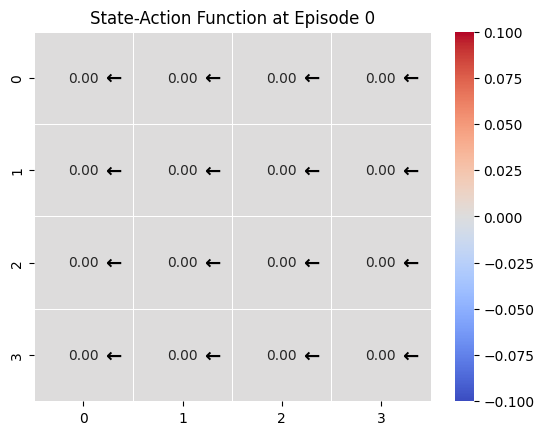

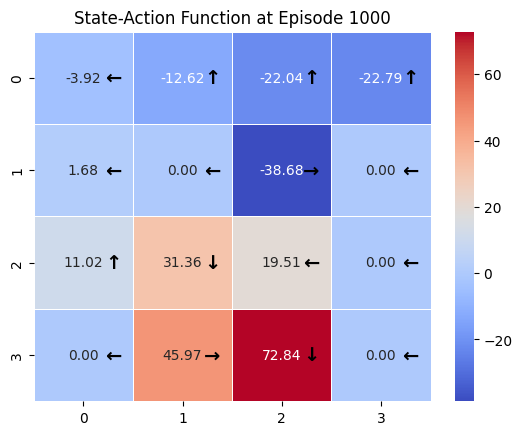

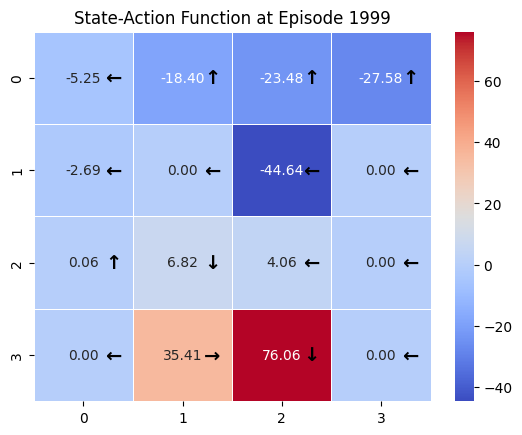

[[-5.25029936e+00 -1.20407246e+01 -1.19580056e+01 -1.23086308e+01]
 [-4.76787702e+01 -5.66127770e+01 -4.96758093e+01 -1.84016705e+01]
 [-4.37594817e+01 -3.44191962e+01 -4.60582593e+01 -2.34809168e+01]
 [-4.85600774e+01 -5.79097729e+01 -5.39595270e+01 -2.75849813e+01]
 [-2.69328079e+00 -2.54799423e+01 -3.23542149e+01 -4.66701173e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.46359381e+01 -6.57002590e+01 -6.96383755e+01 -7.13330271e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.36928607e+01 -4.02983270e+01 -1.81086890e+01  5.51432217e-02]
 [-7.49702692e+00  6.81778753e+00 -2.15798976e+01 -1.55924726e+01]
 [ 4.06137570e+00 -2.80002948e+01 -3.25793811e+01 -3.86691343e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.18834120e+01  1.55816439e+00  3.54146233e+01 -4.44099782e+00]
 [ 3.56187732e+01  7.60628096e+01  4.72990340e+01  3.70072687e

In [5]:
env = gym.make("FrozenLake-v1")
env=CustomFrozenLakeWrapper(env)
agent=SARSA_Agent(env)
agent.train(2000,visualize_interval=1000)

#### Custom Cliff Walker Environment

A . . C . . 
. . . . . . 
. . . . . . 
. . . C . . 
. . . C . . 
. . . C . G 


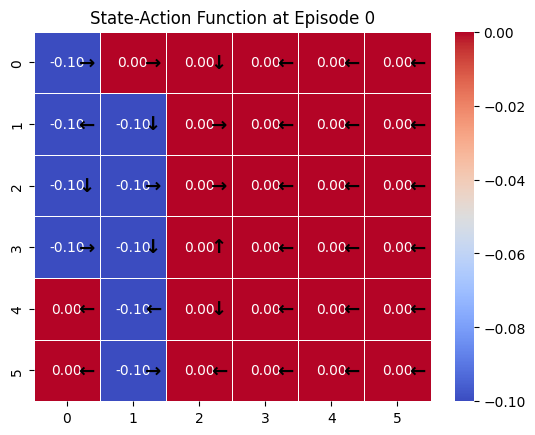

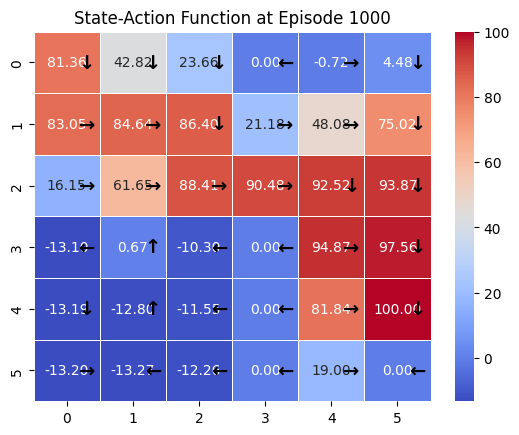

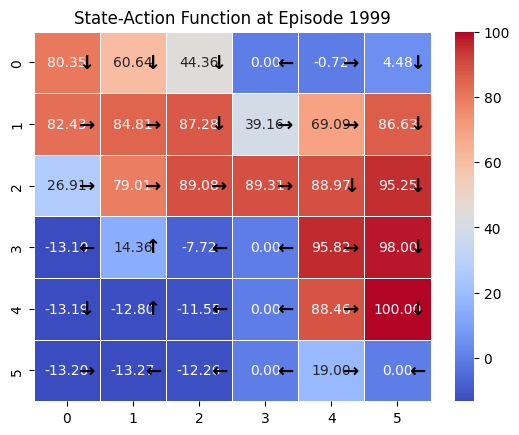

[[ 25.73675151  80.35430053  16.94249938  -2.91231836]
 [-13.45697787  60.63741463 -13.62516875 -13.48024817]
 [-12.28852447  44.36367551 -81.46979811 -16.06905559]
 [  0.           0.           0.           0.        ]
 [-52.17031     -1.02417901  -0.72213685  -5.35133097]
 [ -5.40212733   4.47951003  -1.23368201  -1.06663819]
 [ 28.4542679   -0.92701403  82.43014667  10.26965933]
 [ 25.12325603  23.68837992  84.80671943  13.31011506]
 [ 38.06960817  87.28305536   3.48402487   6.93662854]
 [ -5.74798684  -8.84389953  39.15772339 -77.12320755]
 [  0.51845335   0.27703232  69.08780814  -6.32582582]
 [ -1.29638657  86.63411193   3.80664527  -1.63053716]
 [-13.15758631 -13.17121992  26.913346   -13.07381957]
 [-12.94917539 -12.94527097  79.01175522 -12.28000395]
 [ 27.99308721 -15.20255869  89.08495961  16.31577314]
 [ 21.02164353 -87.84233454  89.30578757  12.73940194]
 [ 46.88133015  88.96960148  55.27006008  16.26803067]
 [ -0.48464626  95.25120757  13.47311429   5.80262134]
 [-13.0950

In [6]:
env=CliffBoy(6,4)
env.render()
agent=SARSA_Agent(env)
agent.train(2000,visualize_interval=1000)

## Q-Learning

In [7]:
class QLearn_Agent():
    def __init__(self,env,alpha=0.1,gamma=0.99):
        self.env=env
        self.alpha=alpha
        self.gamma=gamma
        self.Q=np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.gridsize=int(np.sqrt(self.env.observation_space.n))
    
    def policy(self):
        return self.env.action_space.sample()
    
    def train(self,episodes=1000,visualize_interval=100):
        for episode in range(episodes):
            state=self.env.reset()[0]
            done=False

            while not done:
                action=self.policy()
                next_state,reward,done,_,_=self.env.step(action)
                self.Q[state][action]+=self.alpha*(reward+self.gamma*(self.Q[next_state].max())-self.Q[state][action])
                state=next_state
            if(episode%visualize_interval==0 or episode==episodes-1):
                self.visualize_Q_value(episode)
        print("Final Q-Table:\n", self.Q)

    def visualize_Q_value(self, episode=-1):
        plt.title(f"State-Action Function at Episode {episode}")

        reshaped = self.Q.reshape(self.gridsize, self.gridsize, self.env.action_space.n)
        max_Q_values = reshaped.max(axis=2)
        best_actions = np.argmax(reshaped, axis=2)

        ax = sns.heatmap(max_Q_values, annot=True, cmap="coolwarm", cbar=True, fmt=".2f", linewidths=0.5)

        action_symbols = ["←", "↓", "→", "↑"]

        for i in range(self.gridsize):
            for j in range(self.gridsize):
                action = best_actions[i, j]
                ax.text(j + 0.8, i + 0.5, action_symbols[action], 
                        ha='center', va='center', fontsize=14, color='black', fontweight='bold')

        plt.show()
        sleep(0.5)


#### Frozen Lake Environment

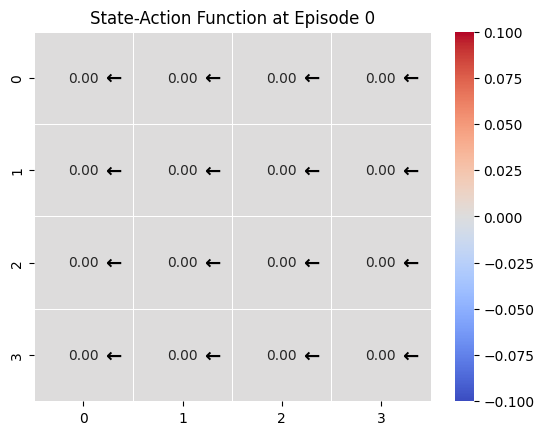

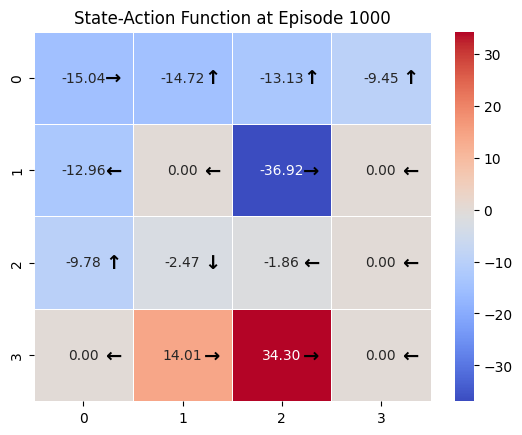

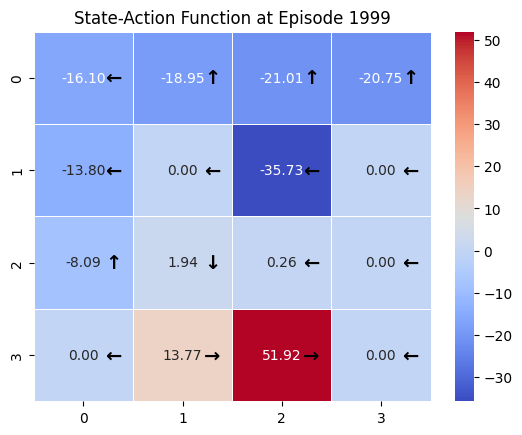

Final Q-Table:
 [[-16.1043006  -16.52390842 -16.92225781 -17.64276039]
 [-60.65121479 -50.87228417 -46.89228355 -18.94554032]
 [-26.55787103 -24.96436818 -28.12933201 -21.01293689]
 [-56.69342971 -43.1254019  -40.41650591 -20.74597714]
 [-13.79756413 -35.36809144 -30.31888493 -49.55038764]
 [  0.           0.           0.           0.        ]
 [-35.72586072 -66.63044631 -43.45761297 -72.36890369]
 [  0.           0.           0.           0.        ]
 [-56.54033187 -17.57764438 -26.24108092  -8.08811737]
 [-22.41921259   1.93856409 -32.89186194 -39.15329028]
 [  0.2614614  -36.87731406 -21.93948763 -48.53641923]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-27.9888814   -9.47980269  13.77207758 -20.30159737]
 [ 12.76961461  31.03041864  51.92142759  24.2310757 ]
 [  0.           0.           0.           0.        ]]


In [8]:
env = gym.make("FrozenLake-v1")
env=CustomFrozenLakeWrapper(env)
agent=QLearn_Agent(env)
agent.train(2000,visualize_interval=1000)

#### Custom Cliff Walker Environment

A . . . . . 
. . . . . . 
. . . . . . 
. . . . . . 
C C C . . C 
. . . . . G 


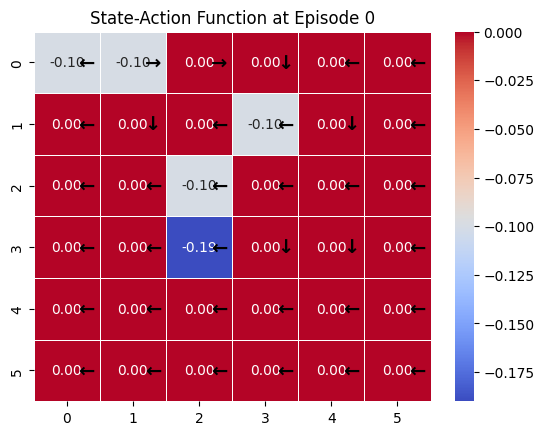

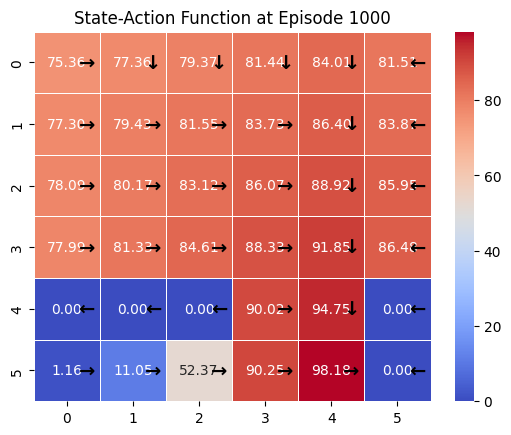

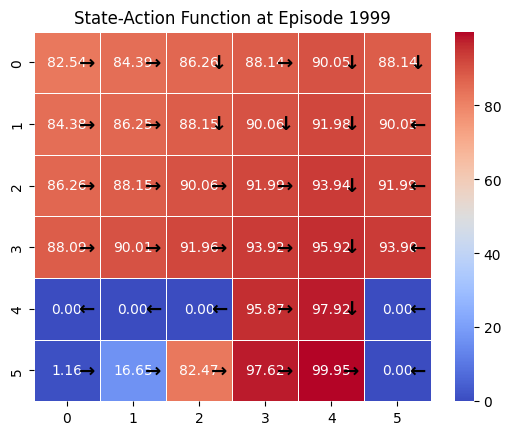

Final Q-Table:
 [[ 8.07081274e+01  8.25378252e+01  8.25383868e+01  8.07086027e+01]
 [ 8.07058415e+01  8.43850706e+01  8.43871819e+01  8.25356485e+01]
 [ 8.25329105e+01  8.62567019e+01  8.62531963e+01  8.43845620e+01]
 [ 8.43819335e+01  8.81415054e+01  8.81425184e+01  8.62477870e+01]
 [ 8.62477456e+01  9.00547441e+01  8.62417144e+01  8.81273753e+01]
 [ 8.81404600e+01  8.81429474e+01  8.62488765e+01  8.62490203e+01]
 [ 8.25348069e+01  8.43836190e+01  8.43845166e+01  8.07047537e+01]
 [ 8.25342646e+01  8.62539530e+01  8.62548973e+01  8.25365750e+01]
 [ 8.43835393e+01  8.81464708e+01  8.81433582e+01  8.43848400e+01]
 [ 8.62498990e+01  9.00561739e+01  9.00552267e+01  8.62482214e+01]
 [ 8.81452559e+01  9.19842388e+01  8.81443972e+01  8.81370380e+01]
 [ 9.00537153e+01  9.00348533e+01  8.81371171e+01  8.62460651e+01]
 [ 8.43813193e+01  8.61952599e+01  8.62550494e+01  8.25335820e+01]
 [ 8.43795137e+01  8.80970484e+01  8.81470723e+01  8.43844321e+01]
 [ 8.62539201e+01  9.00230206e+01  9.00587085e

In [9]:
env=CliffBoy(6,4)
agent=QLearn_Agent(env)
env.render()
agent.train(2000,visualize_interval=1000)